# **Identification**

* **Name:** Joaquim Daniel Rios da Cunha
* **Student Number:** 201806651

* **Name:** Pedro Miguel Pinto Silva
* **Student Number:** 201806526

# Context

The problem was divided in two steps (cascade process), corresponding to 2 different datasets:
- Detection of ROI, that is, the region of the image that have the license plate
- Character extraction, that is, identify the region of each character individually and get the corresponding character until having the full license plate 

Each dataset has its own labels.
- https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
- https://www.kaggle.com/datasets/francescopettini/license-plate-characters-detection-ocr

We approached this problem based on the paper "Computer Vision based License Plate Detection for Automated Vehicle Parking Management System", https://ieeexplore.ieee.org/document/9298091

In Part A and in the first method of Part B we followed the methods explained in this paper. As the results were not what was expected in Part B, we tried our own method based on OpenCV operations that we learned in this course. 


# Part A - License Plate Detection using YOLOv5 

In [ ]:
import os
import cv2
import yaml
import random
import numpy as np
import pandas as pd
import plotly.express as px
import xml.etree.ElementTree as xet


from glob import glob
from skimage import io
from shutil import copy
from google.colab.patches import cv2_imshow
from google.colab import files

import torch
from IPython.display import Image, clear_output  # to display images

## 1\. Load dataset for YOLO v5

In [ ]:
train = False

In [ ]:
# downloading datasets
if not os.path.exists('dataset1'):
    !wget --output-document=dataset1.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/ETX4xFICL9ZNl15HJkxlMgQBaGpdysmeNvWkC26zh-6Ccg?download=1"
    !unzip -q dataset1.zip
    !rm dataset1.zip
    

--2022-12-09 17:41:00--  https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/ETX4xFICL9ZNl15HJkxlMgQBaGpdysmeNvWkC26zh-6Ccg?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/dataset1.zip?ga=1 [following]
--2022-12-09 17:41:01--  https://uporto-my.sharepoint.com/personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/dataset1.zip?ga=1
Reusing existing connection to uporto-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 212891379 (203M) [application/x-zip-compressed]
Saving to: ‘dataset1.zip’

dataset1.zip        100%[===================>] 203.03M  51.6MB/s    in 5.6s    

2022-12-09 17:41:07 (36.5 MB/s) - ‘dataset1.zip’ saved [212891379/212891

## 2\. Dataset information extraction (xml readings)

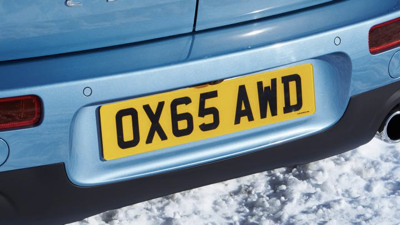

In [ ]:
path = glob('./dataset1/annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./dataset1/images',filename_image)
    return filepath_image
getFilename(filename)

image_path = list(df['filepath'].apply(getFilename))
image_path[:10]   #random check

file_path = image_path[87]  
img = cv2.imread(file_path) 

cv2_imshow(img)

## 3\. Load YOLOv5 

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r ./yolov5/requirements.txt

clear_output()

In [ ]:
!mkdir ./yolov5/data_images/
!mkdir ./yolov5/data_images/test/
!mkdir ./yolov5/data_images/train/

### 3.1 Modifying the dataset to be compatible with YOLO
The original dataset has the coordinates for the bounding box of each license plate.

The YOLO operates with the center coordinates and the width and height, so it is necessary to adjust.


In [ ]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'./dataset1/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height

In [ ]:
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

,filepath,xmin,xmax,ymin,ymax,filename,width,height,center_x,center_y,bb_width,bb_height
0,./dataset1/annotations/Cars262.xml,243,285,184,205,./dataset1/images/Cars262.png,400,301,0.66000,0.646179,0.1050,0.069767
1,./dataset1/annotations/Cars285.xml,91,163,111,134,./dataset1/images/Cars285.png,400,267,0.31750,0.458801,0.1800,0.086142
2,./dataset1/annotations/Cars131.xml,19,497,29,245,./dataset1/images/Cars131.png,500,300,0.51600,0.456667,0.9560,0.720000
3,./dataset1/annotations/Cars293.xml,64,130,160,181,./dataset1/images/Cars293.png,400,267,0.24250,0.638577,0.1650,0.078652
4,./dataset1/annotations/Cars222.xml,178,235,158,170,./dataset1/images/Cars222.png,400,230,0.51625,0.713043,0.1425,0.052174


## 4\. Dataset Spliting
Splitting the dataset of size 433 in 300 images for trainning and 133 for testing.

In [ ]:
### split the data into train and test
df_train = df.iloc[:300]
df_test = df.iloc[300:]

In [ ]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

In order to train for a custom dataset and labeling, it is necessary to build a .yaml file regarding the new labels and the location of the train and validation data.

In [ ]:
dict_file = {'train' : 'data_images/train' , 
             'val'   : 'data_images/test',
             'nc' : 1,
             'names' : ['license_plate'] }

with open('./dataset1/data.yaml', 'w') as file:
    yaml.dump(dict_file, file, default_flow_style=False)

## 5\. Getting the model

In [ ]:
# Load the folder with the images for report

if not os.path.exists('report_images'):
    !wget --output-document=report_images.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/EcEgEXLvb_RDqed1EwUcge0BRpw_ubtCtMnWHnj1Q5hPGg?download=1"
    !unzip -q report_images.zip
    

--2022-12-10 14:42:46--  https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/EcEgEXLvb_RDqed1EwUcge0BRpw_ubtCtMnWHnj1Q5hPGg?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/report_images.zip?ga=1 [following]
--2022-12-10 14:42:47--  https://uporto-my.sharepoint.com/personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/report_images.zip?ga=1
Reusing existing connection to uporto-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 650152 (635K) [application/x-zip-compressed]
Saving to: ‘report_images.zip’

report_images.zip   100%[===================>] 634.91K  1.58MB/s    in 0.4s    

2022-12-10 14:42:48 (1.58 MB/s) - ‘report_images.zip’ saved 

### 5.1 Trainning a new model

We trained two times with different batch size and 20 iterations.
- batch = 8 (that is not divisible by the size of training dataset, 300)
- batch = 10 

In [ ]:
def resize_img(image, width):
  
  img_h, img_w, _ = image.shape
  # Resize all images to a specific width (300px)
  ratio = img_w / width
  dim = (width, (int) (img_h/ratio))
  dst = cv2.resize(image, dim, interpolation = cv2.INTER_CUBIC)
  return dst

# define a function for horizontally 
# concatenating images of different
# heights 
def hconcat_resize(img_list,interpolation = cv2.INTER_CUBIC):
  # take minimum hights
  h_min = min(img.shape[0] for img in img_list)
    
  # image resizing 
  im_list_resize = [cv2.resize(img,
                                (int(img.shape[1] * h_min / img.shape[0]), h_min), 
                                interpolation = interpolation)
                                for img in img_list]
    
  # return final image
  return cv2.hconcat(im_list_resize)


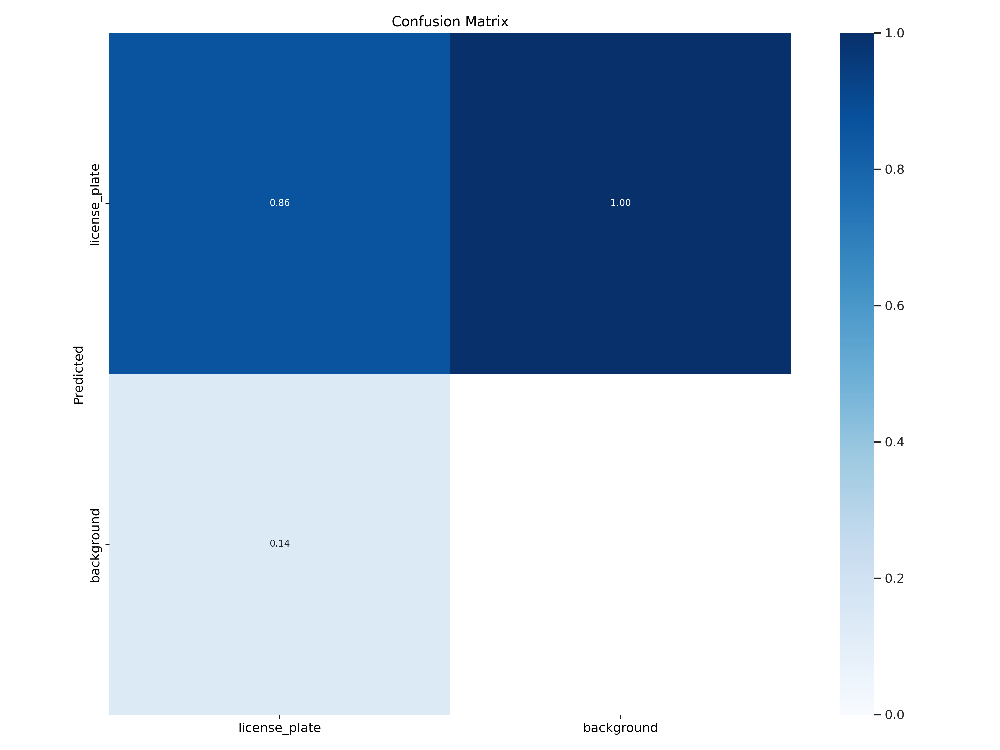

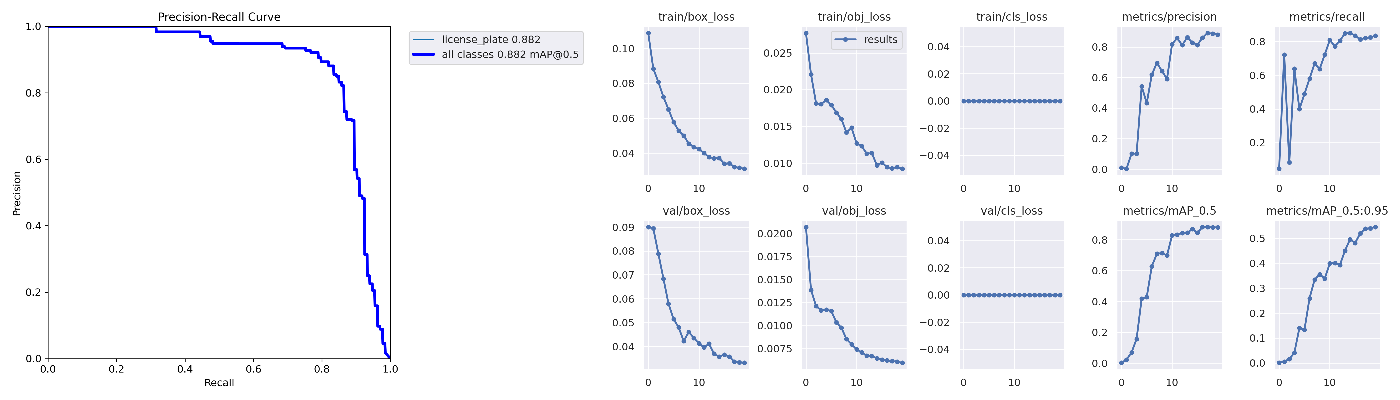

In [ ]:
# For batch size 8
# if(train):
#   ## train the model
#   !python ./yolov5/train.py --data ./dataset1/data.yaml --cfg ./yolov5/models/yolov5s.yaml  --batch-size 8 --name model_name --epochs 20 --cache

conf_matrix = cv2.imread("./report_images/best_model/confusion_matrix.png")
PRcurve = cv2.imread("./report_images/best_model/PR_curve.png")
results = cv2.imread("./report_images/best_model/results.png")

# Resize images to 500px width
conf_matrix = resize_img(conf_matrix, width=1000)
PRcurve = resize_img(PRcurve, width=600)
results = resize_img(results, width=800)
# # function calling
img_h_resize = hconcat_resize([PRcurve, results])
  
# show the Output image
cv2_imshow(conf_matrix)
cv2_imshow(img_h_resize)
# cv2_imshow(Pcurve)
# cv2_imshow(results)



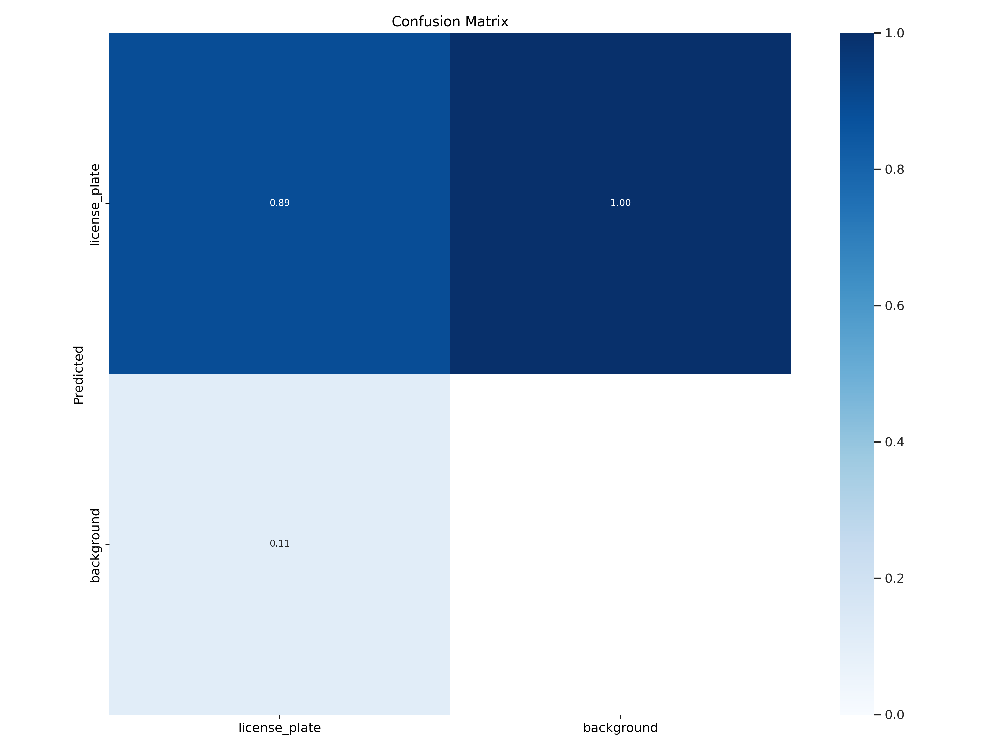

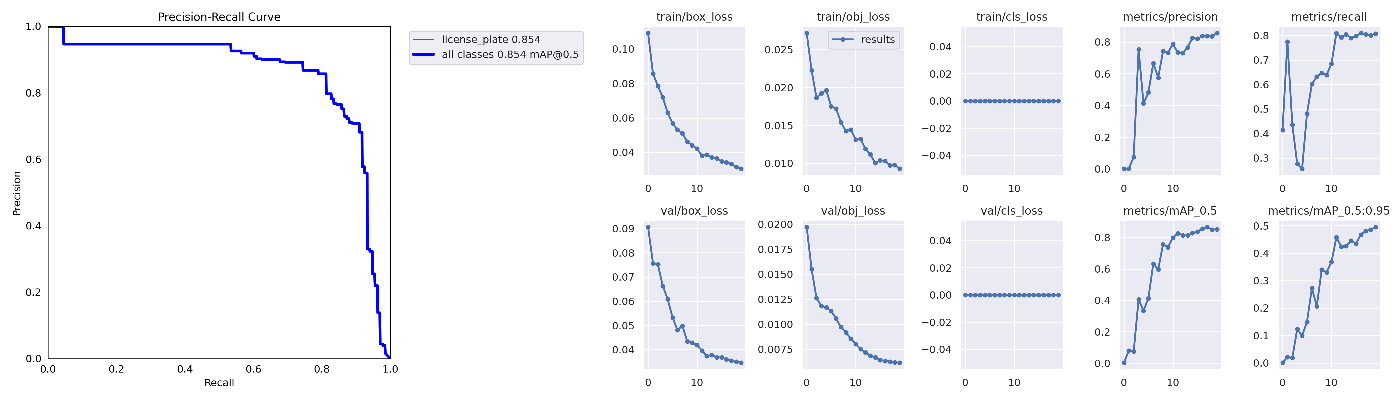

In [ ]:
# For batch size 10
# if(train):
#   ## train the model
#   !python ./yolov5/train.py --data ./dataset1/data.yaml --cfg ./yolov5/models/yolov5s.yaml  --batch-size 10 --name model_name --epochs 20 --cache

conf_matrix = cv2.imread("./report_images/another_train/confusion_matrix.png")
PRcurve = cv2.imread("./report_images/another_train/PR_curve.png")
results = cv2.imread("./report_images/another_train/results.png")

# Resize images to 500px width
conf_matrix = resize_img(conf_matrix, width=1000)
PRcurve = resize_img(PRcurve, width=600)
results = resize_img(results, width=800)
# # function calling
img_h_resize = hconcat_resize([PRcurve, results])
  
# show the Output image
cv2_imshow(conf_matrix)
cv2_imshow(img_h_resize)
# cv2_imshow(Pcurve)
# cv2_imshow(results)


After evaluating the previous trained models, we choose the second one because it has a better performance comparing both with the ideal Precision Recall curve. In other words, for the same precision, the second model have a higger recall, that means that the models classifies less false negatives.



In [ ]:
if(train):
  ## train the model
  !python ./yolov5/train.py --data ./dataset1/data.yaml --cfg ./yolov5/models/yolov5s.yaml  --batch-size 10 --name model_name --epochs 20 --cache

In [ ]:
if(train):  
  ## export the model
  w_path = "./yolov5/runs/train/model_name/weights/best.pt"
  !python ./yolov5/export.py --weights w_path --include torchscript onnx

In [ ]:
if(train):
  ## inference/test model
  w_path = "./yolov5/runs/train/model_name/weights/best.pt"
  !python ./yolov5/detect.py --source ./yolov5/data_images/test/ --weights w_path  
  clear_output()
  
  ## For showing the results
  cnt = 0
  res = glob('./yolov5/runs/detect/exp/*.png')
  for path in res:
 
    if(cnt == 10):
      break
    cnt += 1
    img = cv2.imread(path)
    cv2_imshow(img)


In [ ]:
if train:
  ## donwload to disk the model
  !zip -r ./trained_model.zip ./yolov5
  files.download('./trained_model.zip')
  clear_output()

### 5.2 Uploading the best trained model trained

In [ ]:
## if it is to use a trained model, it necessary to download it    
if(train == False):
  if not os.path.exists('best_model'):
    !wget --output-document=best_model.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/EV77qome9ZNBsidKukZn7uwBZXTekAdJOlgBu8unBY1r1Q?download=1"
    !unzip -q best_model.zip
    !rm best_model.zip

--2022-12-09 17:43:54--  https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/EV77qome9ZNBsidKukZn7uwBZXTekAdJOlgBu8unBY1r1Q?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/best_model.zip?ga=1 [following]
--2022-12-09 17:43:55--  https://uporto-my.sharepoint.com/personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/best_model.zip?ga=1
Reusing existing connection to uporto-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 30820019 (29M) [application/x-zip-compressed]
Saving to: ‘best_model.zip’

best_model.zip      100%[===================>]  29.39M  9.53MB/s    in 3.1s    

2022-12-09 17:43:58 (9.53 MB/s) - ‘best_model.zip’ saved [30820019/3

## 6\. Some statistics about the testing 

In [ ]:
def parsing_XY(path):
    parser = xet.parse(path).getroot()
    xmin,ymin,xmax,ymax = [],[],[],[]

    for parser_XY in parser.iter('object'):
      parser_XY = parser_XY.find('bndbox')   
      xmin.append(float(parser_XY.find('xmin').text))
      ymin.append(float(parser_XY.find('ymin').text))
      xmax.append(float(parser_XY.find('xmax').text))
      ymax.append(float(parser_XY.find('ymax').text))
    
    return xmin, ymin, xmax, ymax

In [ ]:
found_less_lics = []
found_exact_lics = []
found_more_lics = []

accr = 0.7

found_accr = []

# Model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./best_model/weights/best.pt') 

# Images
res = glob('./yolov5/data_images/test/*.png')
for path in res:

  split =  path.split('/')
  img_name = split[len(split)-1]
  
  file = img_name.split('.')
  xml_name = file[0] + ".xml"
  #print(xml_name)
  xmin, ymin, xmax, ymax = parsing_XY("./dataset1/annotations/"+ xml_name)
  
  elem = []
  elem.append(xmin)
  elem.append(ymin)
  elem.append(xmax)
  elem.append(ymax)

  truth_elem = len(xmin)

  results = model(path)
  res = results.pandas().xyxy[0]
  #results.save()

  xmin_est,ymin_est,xmax_est,ymax_est = [],[],[],[]
  for idx,row in res.iterrows():
    
    xm = float(row['xmin'])
    ym = float(row['ymin'])
    xM = float(row['xmax'])
    yM = float(row['ymax'])
    xmin_est.append(xm)
    ymin_est.append(ym)
    xmax_est.append(xM)
    ymax_est.append(yM)

    if float(row['confidence']) >= accr:
      lic_plate = []
      lic_plate.append(img_name)
      lic_plate.append(xm)
      lic_plate.append(ym)
      lic_plate.append(xM)
      lic_plate.append(yM)

      found_accr.append(lic_plate)
  
  elem_est = []
  elem_est.append(xmin_est)
  elem_est.append(ymin_est)
  elem_est.append(xmax_est)
  elem_est.append(ymax_est)

  aux = []
  aux.append(img_name)
  aux.append(elem)
  aux.append(elem_est)

  detected_elem = len(res)
  if detected_elem < truth_elem:
    found_less_lics.append(aux)

  elif detected_elem == truth_elem:
    found_exact_lics.append(aux)

  else:
    found_more_lics.append(aux)


total_img = len(found_less_lics) + len(found_exact_lics) + len(found_more_lics)

print("Detected n license plates vs n of licenses in the gnd truth image")
print("   Total images: " , total_img)
print("   Matches less: " , len(found_less_lics))
print("   Matches exact: ", len(found_exact_lics))
print("   Matches more: " , len(found_more_lics))

print("Detection with more or equal accuracy (", accr,"): ",len(found_accr))


/usr/local/lib/python3.8/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-12-9 Python-3.8.16 torch-1.13.0+cu116 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Detected n license plates vs n of licenses in the gnd truth image
   Total images:  133
   Matches less:  11
   Matches exact:  107
   Matches more:  15
Detection with more or equal accuracy ( 0.7 ):  99


The results above are related with the number of license plates detected and it comparision with the label.
For instance, if it is not detected any region, it is registered in the "Less".
The same for the "More", that is, if the model predicts more licenses then exists in the labels. In the case of "Exact", the model predicts the same number of license plates comparing with the ground truth.

## 7\. Visualize some results

In [ ]:
def show_results(vec,n=2):
  for i in range(n):
    pos = random.randint(0,len(vec)-1)

    # extract image name
    image_name = vec[pos][0]

    # extract number of plates in the gnd truth
    n_gnd = len(vec[pos][1][0])

    # extract number of plates that the model detected
    n_est = len(vec[pos][2][0])

    img = cv2.imread('./dataset1/images/' + image_name)

    print("GND: red")
    print("EST: blue")

    # draw the gnd truth
    for iter in range(n_gnd):
      xmin = int(vec[pos][1][0][iter])
      ymin = int(vec[pos][1][1][iter])
      xmax = int(vec[pos][1][2][iter])
      ymax = int(vec[pos][1][3][iter])
      start_point = (xmin,ymin)
      end_point = (xmax,ymax)
      color = (0,0,255)
      img = cv2.rectangle(img,start_point,end_point,color,thickness=2)
      

    # draw the gnd truth
    for iter in range(n_est):
      xmin = int(vec[pos][2][0][iter])
      ymin = int(vec[pos][2][1][iter])
      xmax = int(vec[pos][2][2][iter])
      ymax = int(vec[pos][2][3][iter])
      start_point = (xmin,ymin)
      end_point = (xmax,ymax)
      color = (255,0,0)
      img = cv2.rectangle(img,start_point,end_point,color,thickness=2)
    
    cv2_imshow(img)
    print(image_name)
    print("")

Detected less license plates comparing to the truth
GND: red
EST: blue


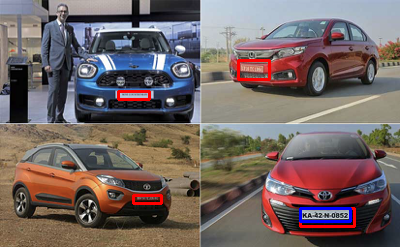

Cars249.png

GND: red
EST: blue


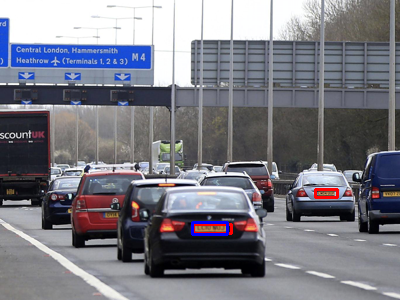

Cars139.png

Detected the exact nº of license plates comparing to the truth
GND: red
EST: blue


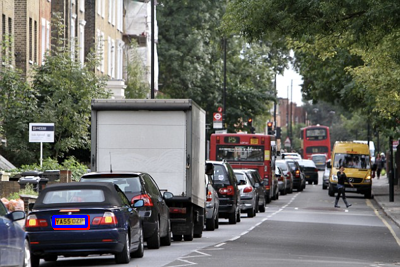

Cars383.png

GND: red
EST: blue


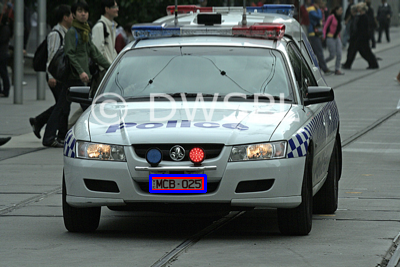

Cars155.png

GND: red
EST: blue


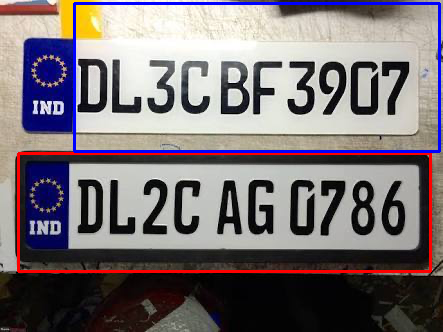

Cars44.png

GND: red
EST: blue


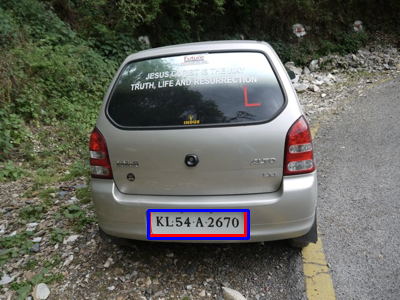

Cars190.png

Detected more license plates comparing to the truth
GND: red
EST: blue


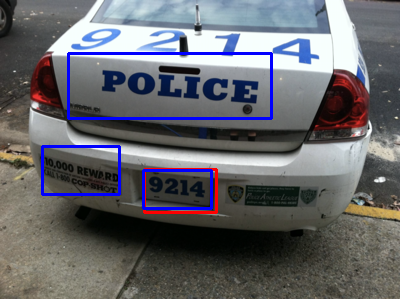

Cars397.png

GND: red
EST: blue


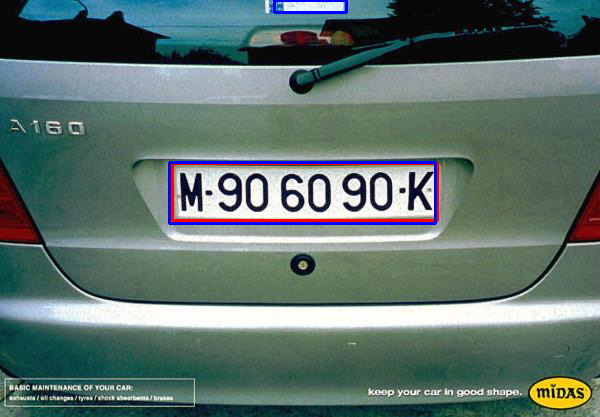

Cars307.png



In [ ]:
n_matches_less = 2
n_matches_exact = 4
n_matches_more = 2

n_accurate = 4

print("Detected less license plates comparing to the truth")
show_results(found_less_lics,n_matches_less)
print("Detected the exact nº of license plates comparing to the truth")
show_results(found_exact_lics,n_matches_exact)
print("Detected more license plates comparing to the truth")
show_results(found_more_lics,n_matches_more)

## 8\. Conclusions

Some of the labels are misclassified, for instance, some cases have two license plates in the image but the label only have one. This problem can distort the results obtained.

Another common problem is the detection of words as license plates because it is more difficult to distinguish, as it can be seen in the above results.

There also situtation where the model detect correctly one license plate but the label only has coordinates for one bounding box. So the model is not wrong but incomplete.

# Part B - License Plate Character Identification

## 1\. Dataset and labels loading

In [ ]:
import cv2
import numpy as np
import pandas as pd
import plotly.express as px
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from google.colab.patches import cv2_imshow
import os

In [ ]:
# downloading datasets
if not os.path.exists('dataset2'):
    !wget --output-document=dataset2_filtered.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/EfoDz14pySZGmYNO98zIqdMBH2GDqgxOWiJzoj4MPF1BNA?download=1"
    !unzip -q dataset2_filtered.zip
    !rm dataset2_filtered.zip

In [ ]:
## label extration from the xml files
import xml.etree.ElementTree as ET

path = glob('./dataset2/annotations/*.xml')
labels_text_dict = dict(filepath=[], lp_text=[] )
cnt = 0
for filename in path:
  # load and parse the file
  xmlTree = ET.parse(filename)
  chars = []
  this_lp_string = ''
  for elem in xmlTree.iter():
      if( elem.tag == 'object' ):
        character = elem.find('name').text
        chars.append(character)
  for x in chars:
    this_lp_string += x
    
  labels_text_dict['filepath'].append(filename)
  labels_text_dict['lp_text'].append(this_lp_string)


df = pd.DataFrame(labels_text_dict)
df.to_csv('labels_text.csv',index=False)
df.head()  

,filepath,lp_text
0,./dataset2/annotations/0233.xml,MH01AR5274
1,./dataset2/annotations/0013.xml,TS09EB1458
2,./dataset2/annotations/0102.xml,DL7SBS6930
3,./dataset2/annotations/0215.xml,MH14TCF460
4,./dataset2/annotations/0164.xml,HR26CT6702


## 2\. Method 1 - Optical Character Recognition (full image)

### 2.1 Pytesseract 

This was the algorythm that was described in the paper we chose to replicate.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import pytesseract as pt

comparing_results = dict(filepath=[], lp_text=[], lp_size=[], lp_det=[], n_chars_correct=[], correct_detection=[] )
correct_guesses=0
total_chars=0
total_chars_correct=0
total_imgs = 0

for index, row in df.iterrows():
  
  filename_image = xet.parse(row['filepath']).getroot().find('filename').text
  filename = os.path.join('./dataset2/images',filename_image)

  lp_text = row['lp_text']
  lp_size = len(lp_text)
  n_chars_correct=0
  correct_detection = False

  img = cv2.imread(filename)
  if img is None:
    continue
  total_imgs+=1

  ## Preprocessing described in the paper
  filtered = cv2.bilateralFilter(src=img,d=11,sigmaColor=175,sigmaSpace=175)
  filtered = cv2.medianBlur(src=filtered, ksize=3)
  filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)


  ## Using pytesseract 
  characters_detected = pt.image_to_string(filtered)
  char_det_w_space = characters_detected.replace(" ","")
  char_det_w_space = char_det_w_space.replace("\n","")

  ## Pytesseract in this version doesnt support character whitelist, so we have to do it by hand
  whitelist_set = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
  char_det_clean = ''
  for c in char_det_w_space:
    if c in whitelist_set:
      char_det_clean+=c


  ## Verify how many characters were properly identified
  for i in range(lp_size):
    if i > len(char_det_clean)-1:
      break
    if lp_text[i] == char_det_clean[i]:
      n_chars_correct+=1
  
  ## If all characters were identified properly, than its a fully correct guess of the license plate
  if n_chars_correct == lp_size and len(char_det_clean) == lp_size:
    correct_detection=True
    correct_guesses+=1

  total_chars += lp_size
  total_chars_correct += n_chars_correct

  comparing_results['filepath'].append(filename)
  comparing_results['lp_text'].append(lp_text)
  comparing_results['lp_size'].append(lp_size)
  comparing_results['lp_det'].append(char_det_clean)
  comparing_results['n_chars_correct'].append(n_chars_correct)
  comparing_results['correct_detection'].append(correct_detection)


print('License plates identified properly (all characters): ' + str(correct_guesses) + ' / ' + str(total_imgs) )
print('Individual characters correct detections: ' + str(total_chars_correct) + ' / ' + str(total_chars) )


df_final = pd.DataFrame(comparing_results)
df_final.to_csv('comparing_results_pytesseract.csv',index=False)
df_final

License plates identified properly (all characters): 18 / 178
Individual characters correct detections: 504 / 1730


,filepath,lp_text,lp_size,lp_det,n_chars_correct,correct_detection
0,./dataset2/images/0233.png,MH01AR5274,10,,0,False
1,./dataset2/images/0102.png,DL7SBS6930,10,,0,False
2,./dataset2/images/0164.png,HR26CT6702,10,HR26CT6702,10,True
3,./dataset2/images/0065.png,TN38M6G162,10,TN38MG6162,8,False
4,./dataset2/images/0132.png,AP20N3100,9,,0,False
...,...,...,...,...,...,...
173,./dataset2/images/0229.png,HR26BP3543,10,,0,False
174,./dataset2/images/0069.png,MH02BM5048,10,,0,False
175,./dataset2/images/0221.png,PB08CX2959,10,PBOBCX2959,8,False
176,./dataset2/images/0022.png,MH03BS7778,10,AMHO3BS7778,2,False


### 2.2 EasyOCR

Using the same algorythm we replaced pytesseract with EasyOCR to see if we can improve the results.

In [ ]:
pip install easyocr

In [ ]:
import easyocr

comparing_results = dict(filepath=[], lp_text=[], lp_size=[], lp_det=[], n_chars_correct=[], correct_detection=[] )
correct_guesses=0
total_chars=0
total_chars_correct=0
total_imgs = 0

for index, row in df.iterrows():
  
  filename_image = xet.parse(row['filepath']).getroot().find('filename').text
  filename = os.path.join('./dataset2/images',filename_image)

  lp_text = row['lp_text']
  lp_size = len(lp_text)
  n_chars_correct=0
  correct_detection = False

  img = cv2.imread(filename)
  if img is None:
    continue
  total_imgs+=1

  ## Preprocessing described in the paper
  filtered = cv2.bilateralFilter(src=img,d=11,sigmaColor=175,sigmaSpace=175)
  filtered = cv2.medianBlur(src=filtered, ksize=3)
  filtered = cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB)


  reader = easyocr.Reader(['en'], verbose=False)
  output = reader.readtext(filtered)
  ## Whitelisting characters like we did with pytesseract
  if output: 
    char_det = output[0][1]
    char_det_w_space = char_det.replace(" ","")
    whitelist_set = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    char_det_clean = ''
    for c in char_det_w_space:
      if c in whitelist_set:
        char_det_clean+=c
  else:
    char_det_clean = ' '


  ## Verify how many characters were properly identified
  for i in range(lp_size):
    if i > len(char_det_clean)-1:
      break
    if lp_text[i] == char_det_clean[i]:
      n_chars_correct+=1
  
  ## If all characters were identified properly, than its a fully correct guess of the license plate
  if n_chars_correct == lp_size and len(char_det_clean) == lp_size:
    correct_detection=True
    correct_guesses+=1

  total_chars += lp_size
  total_chars_correct += n_chars_correct

  comparing_results['filepath'].append(filename)
  comparing_results['lp_text'].append(lp_text)
  comparing_results['lp_size'].append(lp_size)
  comparing_results['lp_det'].append(char_det_clean)
  comparing_results['n_chars_correct'].append(n_chars_correct)
  comparing_results['correct_detection'].append(correct_detection)


print('License plates identified properly (all characters): ' + str(correct_guesses) + ' / ' + str(total_imgs) )
print('Individual characters correct detections: ' + str(total_chars_correct) + ' / ' + str(total_chars) )


df_final = pd.DataFrame(comparing_results)
df_final.to_csv('comparing_results_easyOCR.csv',index=False)
df_final

License plates identified properly (all characters): 17 / 178
Individual characters correct detections: 697 / 1730


,filepath,lp_text,lp_size,lp_det,n_chars_correct,correct_detection
0,./dataset2/images/0233.png,MH01AR5274,10,,0,False
1,./dataset2/images/0102.png,DL7SBS6930,10,DLZS,3,False
2,./dataset2/images/0164.png,HR26CT6702,10,HR26Ct6702,9,False
3,./dataset2/images/0065.png,TN38M6G162,10,TN38,4,False
4,./dataset2/images/0132.png,AP20N3100,9,,0,False
...,...,...,...,...,...,...
173,./dataset2/images/0229.png,HR26BP3543,10,HR268P3543,9,False
174,./dataset2/images/0069.png,MH02BM5048,10,MIH02KMSUAS,1,False
175,./dataset2/images/0221.png,PB08CX2959,10,Pb08CX2959,9,False
176,./dataset2/images/0022.png,MH03BS7778,10,MHO3BS7778,9,False


### 2.3 Results discussion

This method was not accurate for the correct identification of all characters in license plates, identifying properly only 10% of the dataset.

However, the EasyOCR has better performance identifying individual characters.
With this, we concluded that the individual character recognition from the EasyOCR maybe an asset that we use for our 2nd method, since it properly identified 40% of all individual characters.

## 3\. Method 2 - Individual Character Detection using OpenCV
In this method, we are going to do pre-processing using OpenCV.

The goal is to apply a cascade of operation in order to build a mask with just the license plate character. With this, it is possible to extract a bounding box for each object and it inclination and perform a rotation of the image making it more horizontal.

After this, with the rotated image, the previous process is applied again to take a new bounding box so it is possible to use the easyOCR for classify each individual character.


### 3.1 Image pre-processing

In [ ]:
#rotate the image with given theta value
def rotate(img, theta):
    rows, cols = img.shape[0], img.shape[1]
    image_center = (cols/2, rows/2)
    
    M = cv2.getRotationMatrix2D(image_center,theta,1)

    abs_cos = abs(M[0,0])
    abs_sin = abs(M[0,1])

    bound_w = int(rows * abs_sin + cols * abs_cos)
    bound_h = int(rows * abs_cos + cols * abs_sin)

    M[0, 2] += bound_w/2 - image_center[0]
    M[1, 2] += bound_h/2 - image_center[1]

    # rotate orignal image to show transformation
    rotated = cv2.warpAffine(img, M, (bound_w, bound_h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [ ]:
def slope(x1, y1, x2, y2):
    if x1 == x2:
        return 0
    slope = (y2-y1)/(x2-x1)
    theta = np.rad2deg(np.arctan(slope))
    return theta

In [ ]:
def identify_boundbox(image):
  # This will work on the image receive and return the bounding boxes around
  # each character of the license plate and its contours

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Apply Gaussian blurring and thresholding 
  # to reveal the characters on the license plate
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  thresh = cv2.adaptiveThreshold(blurred, 255,
      cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)

  # Perform connected components analysis on the thresholded image and
  # initialize the mask to hold only the components we are interested in
  _, labels = cv2.connectedComponents(thresh)
  mask = np.zeros(thresh.shape, dtype="uint8")
  mask_filtered = np.zeros(thresh.shape, dtype="uint8")
  
  # Set lower bound and upper bound criteria for characters
  total_pixels = image.shape[0] * image.shape[1]
  lower = total_pixels // 220 # heuristic param, can be tuned if necessary
  upper = total_pixels // 20  # heuristic param, can be tuned if necessary

  # Loop over the unique components
  for (i, label) in enumerate(np.unique(labels)):
      
      # If this is the background label, ignore it
      if label == 0:
          continue
  
      # Otherwise, construct the label mask to display only connected component
      # for the current label
      labelMask = np.zeros(thresh.shape, dtype="uint8")
      labelMask[labels == label] = 255
      numPixels = cv2.countNonZero(labelMask)
      # If the number of pixels in the component is between lower bound and upper bound, 
      # add it to our mask and save the numPixels for future outlier treatment
      if numPixels > lower and numPixels < upper:
          mask = cv2.add(mask, labelMask)
  # cv2_imshow(mask)
  # Find contours and get bounding box for each contour
  cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # cnts = sorted(cnts, key = cv2.contourArea, reverse = False)
  boundingBoxes = [cv2.boundingRect(c) for c in cnts]

  return (cnts, boundingBoxes)

In [ ]:
def deskew(path, image, contours):

  # Extract image name, that is, the last position in the path
  image_name = path.split('/')
  image_name = image_name[len(image_name) - 1]

  textImg = image.copy()
  # save theta value for each bounding box
  # in order to rotate the original image
  bb_theta = []
  
  for idx in range(len(cnts)):
      
      rect = cv2.minAreaRect(cnts[idx])
      box = cv2.boxPoints(rect)
      box = np.int0(box)
      cv2.drawContours(textImg,[box],0,(0,0,255),2)

      #we can filter theta as outlier based on other theta values
      #this will help in excluding the rare text region with different orientation from ususla value 
      theta = slope(box[0][0], box[0][1], box[1][0], box[1][1])
      if theta < -45:
        theta = (theta+90)
      bb_theta.append(theta)
          
  #find the average of all cumulative theta value
  orientation = sum(bb_theta) / len(bb_theta)
 
  #print("Image orientation in degress: ", orientation)
  finalImage = rotate(image, orientation)
  cv2.imwrite("./bb_original/"+image_name, textImg)
  # cv2_imshow(textImg)
  # # print(orientation)
  # cv2_imshow(finalImage)
  cv2.imwrite("./rotated/"+image_name, finalImage)


In [ ]:
!mkdir ./rotated
!mkdir ./bb_original

#### 3.1.1 Normalize image size and apply rotations

In [ ]:
def resize_img(image, width):

  img_h, img_w, _ = image.shape
  # Resize all images to a specific width (300px)
  ratio = img_w / width
  dim = (width, (int) (img_h/ratio))
  dst = cv2.resize(image, dim, interpolation = cv2.INTER_CUBIC)
  return dst

# define a function for horizontally 
# concatenating images of different
# heights 
def hconcat_resize(img_list,interpolation = cv2.INTER_CUBIC):
  # take minimum hights
  h_min = min(img.shape[0] for img in img_list)
    
  # image resizing 
  im_list_resize = [cv2.resize(img,
                                (int(img.shape[1] * h_min / img.shape[0]), h_min), 
                                interpolation = interpolation)
                                for img in img_list]
    
  # return final image
  return cv2.hconcat(im_list_resize)

In [ ]:
path = glob('./dataset2/images/*.png')
for i in path:

  image = cv2.imread(i)
  
  # Resize all images to a specific width (300px)
  image = resize_img(image,width=300)

  # Boundig boxes and contours of each character identified
  cnts,_ = identify_boundbox(image)
  
  # Rotate the image to a more horizontal position and save the result
  # in the folder ./rotated
  # Also save the original image with the bounding boxes that cause the rotation
  # in the folder ./bb_original
  deskew(i,image,cnts)


Resized -> Resized with bounding box -> Rotated


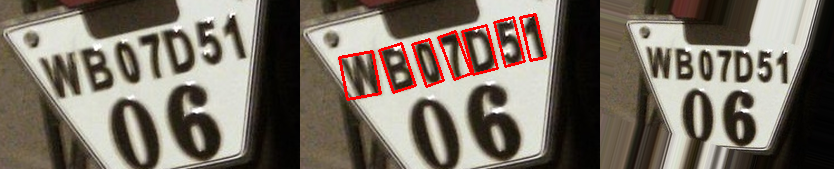

Resized -> Resized with bounding box -> Rotated


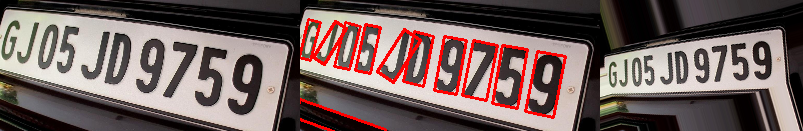

In [ ]:
example_for_result = ['0066.png', '0030.png']
for i in range(2):
  
  original = cv2.imread( './dataset2/images/' + example_for_result[i] )
  original = resize_img(original, width=300)
  original_bb =  cv2.imread( './bb_original/' + example_for_result[i] )
  rotated =  cv2.imread('./rotated/' + example_for_result[i])
  
  print("Resized -> Resized with bounding box -> Rotated")
  res_hconcat = hconcat_resize([original, original_bb, rotated])
  cv2_imshow(res_hconcat)


 ### 3.2 Individual Character extraction and classification

In [ ]:
import functools
import easyocr

In [ ]:
# Sort the bounding boxes from left to right, top to bottom
# sort by Y first, and then sort by X if Ys are similar
def compare(rect1, rect2):
  if abs(rect1[1] - rect2[1]) > 10:
    return rect1[1] - rect2[1]
  else:
    return rect1[0] - rect2[0]

In [ ]:
comparing_results = dict(filepath=[], lp_text=[], lp_size=[], lp_det=[], n_chars_correct=[], correct_detection=[] )
correct_guesses=0
total_chars=0
total_chars_correct=0
total_imgs = 0

for index, row in df.iterrows():
  
  filename_image = xet.parse(row['filepath']).getroot().find('filename').text
  filename = os.path.join('./dataset2/images',filename_image)

  lp_text = row['lp_text']
  lp_size = len(lp_text)
  n_chars_correct=0
  correct_detection = False

  image = cv2.imread('./rotated/' + filename_image)
  if image is None:
    continue
  total_imgs+=1
  # print("Itr: ",total_imgs)
  result = image.copy()
  # Boundig boxes and contours of each character identified
  cnts,boundingBoxes = identify_boundbox(image)
  
  # Sort BB by top left point position
  boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )
  
  license_plate = ''
  pad = 5
  for bb in boundingBoxes:
    x,y,w,h = bb
    if (w < pad) or (h < pad):
      continue
    
    y_min = y-pad 
    y_max = y+h+pad
    x_min = x-pad
    x_max = x+w+pad

    if (y_min < 0):
      y_min = 0
    if (x_min < 0):
      x_min = 0
    if ( x_max > image.shape[1]):
      x_max = image.shape[1]
    if ( y_max > image.shape[0]):
      y_max = image.shape[0]

    color_red = (0, 0, 255)
    cv2.rectangle(result, (x_min, y_min), (x_max, y_max), color_red, 2)
    
    cropped = image[y_min : y_max, x_min: x_max]
    # cv2_imshow(cropped)
    reader = easyocr.Reader(['en'], verbose=False)
    output = reader.readtext(cropped)
    if output: 
      license_plate += output[0][1]
  #cv2_imshow(result)
  #print(filename_image)
  #print("Detection", license_plate) 
     
  ## Whitelisting characters like we did with pytesseract
  whitelist_set = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
  char_det_clean = ''

  if len(license_plate) > 0:
    for c in license_plate:
      if c in whitelist_set:
        char_det_clean+=c
  else:
    char_det_clean = ' '

  ## Verify how many characters were properly identified
  for i in range(lp_size):
    if i > len(char_det_clean)-1:
      break
    if lp_text[i] == char_det_clean[i]:
      n_chars_correct+=1
  
  ## If all characters were identified properly, than its a fully correct guess of the license plate
  if n_chars_correct == lp_size and len(char_det_clean) == lp_size:
    correct_detection=True
    correct_guesses+=1

  total_chars += lp_size
  total_chars_correct += n_chars_correct

  comparing_results['filepath'].append(filename)
  comparing_results['lp_text'].append(lp_text)
  comparing_results['lp_size'].append(lp_size)
  comparing_results['lp_det'].append(char_det_clean)
  comparing_results['n_chars_correct'].append(n_chars_correct)
  comparing_results['correct_detection'].append(correct_detection)


print('License plates identified properly (all characters): ' + str(correct_guesses) + ' / ' + str(total_imgs) )
print('Individual characters correct detections: ' + str(total_chars_correct) + ' / ' + str(total_chars) )

df_final = pd.DataFrame(comparing_results)
df_final.to_csv('comparing_results_ours.csv',index=False)
df_final


License plates identified properly (all characters): 22 / 178
Individual characters correct detections: 683 / 1730


,filepath,lp_text,lp_size,lp_det,n_chars_correct,correct_detection
0,./dataset2/images/0233.png,MH01AR5274,10,NF,0,False
1,./dataset2/images/0102.png,DL7SBS6930,10,SIDS6930,1,False
2,./dataset2/images/0164.png,HR26CT6702,10,HER26CT6702,1,False
3,./dataset2/images/0065.png,TN38M6G162,10,TeN38MG6162,2,False
4,./dataset2/images/0132.png,AP20N3100,9,,0,False
...,...,...,...,...,...,...
173,./dataset2/images/0229.png,HR26BP3543,10,HR26BP3543,10,True
174,./dataset2/images/0069.png,MH02BM5048,10,I2BM,0,False
175,./dataset2/images/0221.png,PB08CX2959,10,2959PBOE18CX,0,False
176,./dataset2/images/0022.png,MH03BS7778,10,MHI3BS7778,9,False


### 3.3 Application in european license plates
The main dataset that we used has many images of license plates in real scenarios, so we decided to test the method with a few optimal images.


--2022-12-09 12:12:27--  https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/EdcB6S410iZMrV_g3edXrW8Bz2vFGGTZqCwmt1kIEWBRPQ?download=1
Resolving uporto-my.sharepoint.com (uporto-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uporto-my.sharepoint.com (uporto-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/european_plates.zip?ga=1 [following]
--2022-12-09 12:12:27--  https://uporto-my.sharepoint.com/personal/up201806651_up_pt/Documents/5ano/1S/CV/projects/Assig2/european_plates.zip?ga=1
Reusing existing connection to uporto-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 16101 (16K) [application/x-zip-compressed]
Saving to: ‘european_plates.zip’

european_plates.zip 100%[===================>]  15.72K  --.-KB/s    in 0s      

2022-12-09 12:12:27 (138 MB/s) - ‘european_plates.zip’ s

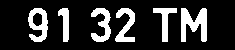

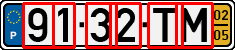

Result:  932TLM


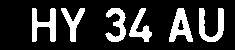

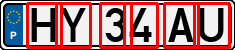

Result:  HY34AU


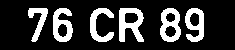

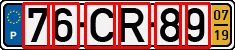

Result:  76CR89


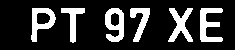

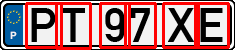

Result:  PT97XE


In [ ]:
# downloading datasets
if not os.path.exists('european_plates'):
    !wget --output-document=european_plates.zip "https://uporto-my.sharepoint.com/:u:/g/personal/up201806651_up_pt/EdcB6S410iZMrV_g3edXrW8Bz2vFGGTZqCwmt1kIEWBRPQ?download=1"
    !unzip -q european_plates.zip
    !rm european_plates.zip

path = glob('./european_plates/*.png')

for img_name in path:

  image = cv2.imread(img_name)
 
  result = image.copy()
  # Boundig boxes and contours of each character identified
  cnts,boundingBoxes = identify_boundbox(image)
  
  # Sort BB by top left point position
  boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )
  
  license_plate = ''
  pad = 5
  for bb in boundingBoxes:
    x,y,w,h = bb
    if (w < pad) or (h < pad):
      continue
    
    y_min = y-pad 
    y_max = y+h+pad
    x_min = x-pad
    x_max = x+w+pad

    if (y_min < 0):
      y_min = 0
    if (x_min < 0):
      x_min = 0
    if ( x_max > image.shape[1]):
      x_max = image.shape[1]
    if ( y_max > image.shape[0]):
      y_max = image.shape[0]

    color_red = (0, 0, 255)
    cv2.rectangle(result, (x_min, y_min), (x_max, y_max), color_red, 2)
    
    cropped = image[y_min : y_max, x_min: x_max]
    # cv2_imshow(cropped)
    reader = easyocr.Reader(['en'], verbose=False)
    output = reader.readtext(cropped)
    if output: 
      license_plate += output[0][1]
  
  cv2_imshow(result)
  print("Result: ", license_plate)

### 3.4 Results discussion
This method identified almost the same ammount of individual characters when comparing to the method in 2.2, but the full license plate identification was slightly better (12%).

This was achieved mostly due to the pre-processing applied, because the dataset that we used has license plates that are not aligned and some even with low quality images.

Our method also commonly fails if the license plate has more visual elements other than only characters, because it detects the bounding box of things that are not elements.
Even with the bounding box being properly identified, easyOCR can still fail at classifying it.

With the purpose of analyzing this last problem, we tested the method with the images presented on 3.3.

We can conclude that the bounding box identification done through OpenCV pre processing was working fine for clear license plates, but the easyOCR often fails at identifying some characters like 1, 4, 0/O, 8/B, J, etc.

Because of this, we suggest that if there was opportunity to improve this method in the future, it would be achieved by replacing the easyOCR by a CNN that would be modelled and trained by us.
